In [1]:
import pandas as pd
import sys
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
#import hdbscan

# 1. Analysis of UMAP results per Transactions

In [13]:
transactions_all = pd.read_csv('Data/Complements/202001_IDs_per_transactions.csv', 
                           index_col='Marketing_Cloud_Visitor_ID')
transactions_all.head(2)

,transaction_type
Marketing_Cloud_Visitor_ID,
00000107708722978450827756473807907358,RENT
00000136845845092372076348413986631894,RENT


In [14]:
compressed_data = pd.read_csv('Data/202001_data_compressed1.csv')
compressed_data = compressed_data.rename(
    columns={'Unnamed: 0' : 'Marketing_Cloud_Visitor_ID'}).set_index('Marketing_Cloud_Visitor_ID')
compressed_data.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3
Marketing_Cloud_Visitor_ID,,,
00000107708722978450827756473807907358,1.862862,-3.838513,3.362385
00000136845845092372076348413986631894,2.388601,-0.954339,1.747901


In [15]:
compressed_data.shape

(744829, 3)

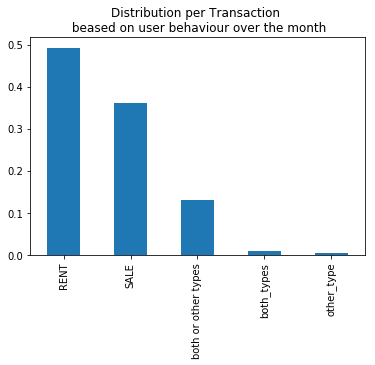

In [17]:
user_transaction = pd.merge(compressed_data, transactions_all, on='Marketing_Cloud_Visitor_ID', how='left')
user_transaction.loc[user_transaction.transaction_type.isnull(), ('transaction_type')] = 'both or other types'
user_transaction = user_transaction.fillna(0)
pd.value_counts(user_transaction['transaction_type'], normalize=True).plot.bar()
plt.title('Distribution per Transaction \n beased on user behaviour over the month')
plt.show()

In [18]:
user_transaction.loc[user_transaction.transaction_type=='no_class', ('transaction_id')] = 0
user_transaction.loc[user_transaction.transaction_type=='RENT', ('transaction_id')] = 1
user_transaction.loc[user_transaction.transaction_type=='SALE', ('transaction_id')] = 2
user_transaction.loc[user_transaction.transaction_type=='both_types', ('transaction_id')] = 3
user_transaction.loc[user_transaction.transaction_type=='other_type', ('transaction_id')] = 4
user_transaction.loc[user_transaction.transaction_type=='both or other types', ('transaction_id')] = 5
user_transaction[['transaction_type', 'transaction_id']].drop_duplicates()

,transaction_type,transaction_id
Marketing_Cloud_Visitor_ID,,
00000107708722978450827756473807907358,RENT,1.0
00000405678892241762669292114416707989,both or other types,5.0
00001292048436699241321243779438039393,SALE,2.0
00004636266278697590670245437416385828,both_types,3.0
00012175578843973492420783600319925773,other_type,4.0


In [19]:
user_transaction.shape

(744829, 5)

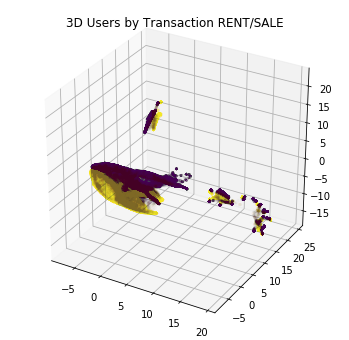

In [21]:
#df_plot = user_transaction.copy()
df_plot = user_transaction[user_transaction.transaction_type.isin(['RENT', 'SALE'])]
plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(df_plot['umap_dim_3'], 
             df_plot['umap_dim_2'], 
             df_plot['umap_dim_1'], 
             c=df_plot['transaction_id'], 
             s=5, 
             alpha=0.007, 
             label=df_plot['transaction_type'])
plt.title('3D Users by Transaction RENT/SALE')
#legend = ax.legend(loc="lower left", title="Classes")
plt.show()

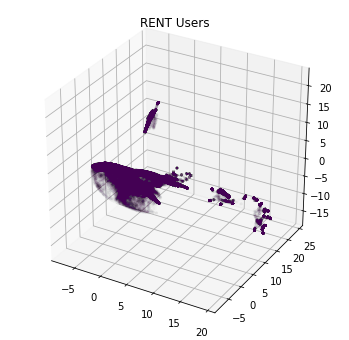

In [22]:
df_plot = user_transaction[user_transaction.transaction_type.isin(['RENT'])]
plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(df_plot['umap_dim_3'], 
             df_plot['umap_dim_2'], 
             df_plot['umap_dim_1'], 
             c=df_plot['transaction_id'], 
             s=5, 
             alpha=0.007, 
             label=df_plot['transaction_type'])
plt.title('RENT Users')
#legend = ax.legend(loc="lower left", title="Classes")
plt.show()

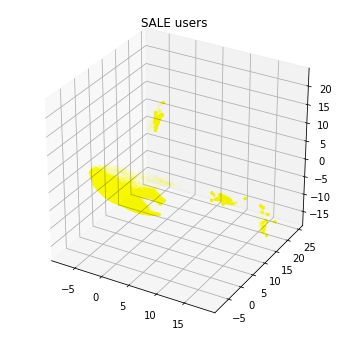

In [23]:
df_plot = user_transaction[user_transaction.transaction_type.isin(['SALE'])]
plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(df_plot['umap_dim_3'], 
             df_plot['umap_dim_2'], 
             df_plot['umap_dim_1'], 
             c='yellow', 
             s=5, 
             alpha=0.007, 
             label=df_plot['transaction_type'])
plt.title('SALE users')
#legend = ax.legend(loc="lower left", title="Classes")
plt.show()

In [17]:
user_transaction.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3,transaction_type,transaction_id
Marketing_Cloud_Visitor_ID,,,,,
00000107708722978450827756473807907358,1.862862,-3.838513,3.362385,RENT,1.0
00000136845845092372076348413986631894,2.388601,-0.954339,1.747901,RENT,1.0


In [18]:
col_drop = ['transaction_type', 'transaction_id']
df_rent = user_transaction[user_transaction.transaction_type=='RENT'].drop(columns=col_drop)
df_sale = user_transaction[user_transaction.transaction_type=='SALE'].drop(columns=col_drop)
df_rent.to_csv('Data/202001_data_compressed_data_rent.csv', index=True)
df_sale.to_csv('Data/202001_data_compressed_data_sale.csv', index=True)

# 2. Clustering per Transaction

In [17]:
# rent users
#df_rent = pd.read_csv('Data/202001_data_compressed_data_rent.csv', index_col='Marketing_Cloud_Visitor_ID')
# sale users
df_sale = pd.read_csv('Data/202001_data_compressed_data_sale.csv', index_col='Marketing_Cloud_Visitor_ID')

RENT

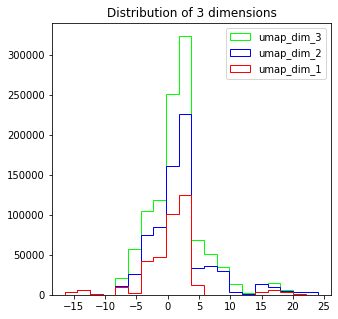

In [3]:
n_bins=20
x = df_rent.transpose()
colors = ['red', 'blue', 'lime']
plt.figure(figsize=(5, 5))
plt.hist(x, n_bins, histtype='step', stacked=True, fill=False, color=colors, label=x.index)
plt.title('Distribution of 3 dimensions')
plt.legend()
plt.show()

In [4]:
df_rent.shape

(366541, 3)

In [6]:
# Cluster rent data
clusterer = hdbscan.HDBSCAN(min_cluster_size=2000, 
                            min_samples=1000, 
                            leaf_size=10,
                            core_dist_n_jobs=2, 
                            metric='euclidean').fit(df_rent)
print('Clusters found (including noise): ' + str(len(np.unique(clusterer.labels_))))
df_rent['label'] = clusterer.labels_.copy()
df_rent['label_probability'] = clusterer.probabilities_.copy()

Clusters found (including noise): 4


In [9]:
df_rent.to_csv('Data/202001_android_rent_clustered.csv', index=True)

SALE

In [18]:
df_sale.shape

(269284, 3)

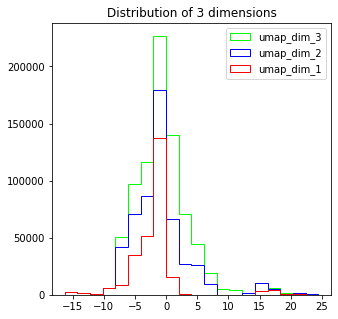

In [19]:
n_bins=20
x = df_sale.transpose()
colors = ['red', 'blue', 'lime']
plt.figure(figsize=(5, 5))
plt.hist(x, n_bins, histtype='step', stacked=True, fill=False, color=colors, label=x.index)
plt.title('Distribution of 3 dimensions')
plt.legend()
plt.show()

In [20]:
# Cluster rent data
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, 
                            min_samples=500, 
                            leaf_size=5,
                            core_dist_n_jobs=2, 
                            metric='euclidean').fit(df_sale)
print('Clusters found (including noise): ' + str(len(np.unique(clusterer.labels_)))

Clusters found (including noise): 9


NameError: name 'df_rent' is not defined

In [21]:
df_sale['label'] = clusterer.labels_.copy()
df_sale['label_probability'] = clusterer.probabilities_.copy()

In [22]:
df_sale.label.unique()

array([ 4,  6,  0,  3, -1,  7,  5,  1,  2])

In [23]:
df_sale.to_csv('Data/202001_android_sale_clustered.csv', index=True)

Analysis of clusters

In [24]:
df_aux = df_sale.copy()

9 clusters


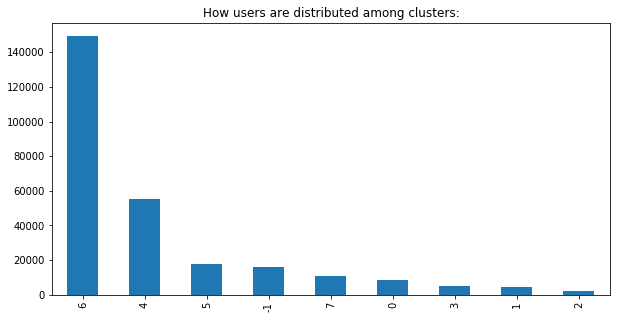

Clusters distribution


In [25]:
print(str(df_aux.label.unique().shape[0]) + ' clusters')
plt.figure(figsize=(10, 5))
plt.title('How users are distributed among clusters:')
pd.value_counts(df_aux['label'], normalize=False).plot.bar()
plt.show()
print('Clusters distribution')

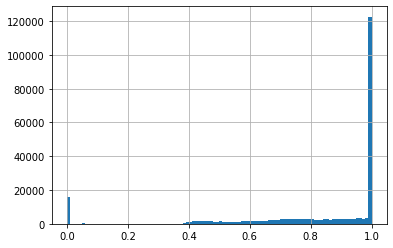

In [26]:
df_aux[df_aux.label_probability>=0].label_probability.hist(bins=100)
plt.show()

In [29]:
treshold = 0.95
print('With confidence level: ' + str(treshold))
m = df_aux[df_aux.label_probability>=treshold].shape[0]
n = round(m/df_aux.shape[0]*100, 2)                                                         
print('We can cluster ' + str(n) + '% of users')

With confidence level: 0.95
We can cluster 50.49% of users


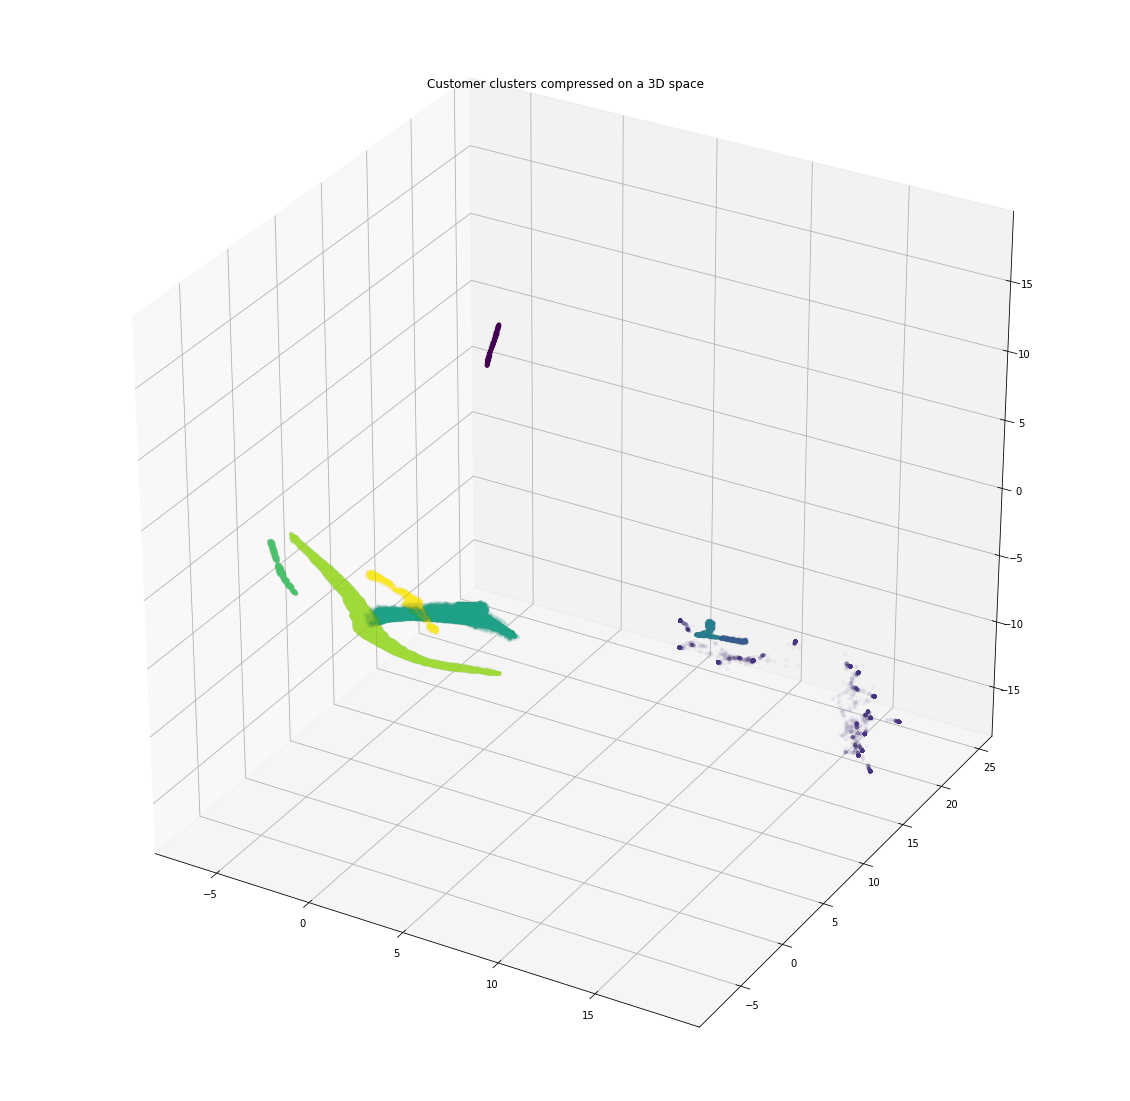

In [31]:
df_plot = df_aux.copy()
#df_plot = df_aux[df_aux.label.isin([2])]
df_plot = df_aux[df_aux.label_probability>=0.95]
plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
ax.scatter3D(df_plot['umap_dim_3'], 
             df_plot['umap_dim_2'], 
             df_plot['umap_dim_1'], 
             c=df_plot['label'], 
             s=10, 
             alpha=0.03, 
             label=df_plot['label'])
plt.title('Customer clusters compressed on a 3D space')
#legend = ax.legend(loc="lower left", title="Classes")
plt.show()

In [32]:
df_aux = df_aux[df_aux.label_probability>=treshold]
print('Now dataframe has shape:')
print(df_aux.shape)

Now dataframe has shape:
(135958, 5)


# Finding a finer clustering

In [60]:
df_rent = pd.read_csv('Data/202001_android_rent_clustered.csv', index_col='Marketing_Cloud_Visitor_ID')

In [61]:
df_rent.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability
Marketing_Cloud_Visitor_ID,,,,,
00000107708722978450827756473807907358,1.862862,-3.838513,3.362385,3,0.77945
00000136845845092372076348413986631894,2.388601,-0.954339,1.747901,3,1.00000


4clusters


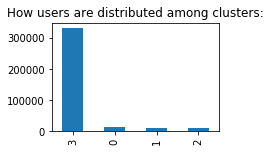

In [62]:
df_aux = df_rent.copy()
print(str(df_aux.label.unique().shape[0]) + 'clusters')
plt.figure(figsize=(3, 2))
plt.title('How users are distributed among clusters:')
pd.value_counts(df_aux['label'], normalize=False).plot.bar()
plt.show()

In [63]:
df_rent = df_rent[df_rent.label==3]
df_rent = df_rent.drop(columns=['label_probability','label'])

In [64]:
df_rent.shape

(331868, 3)

In [65]:
# Clustering a subset of clusters of rent data
clusterer = hdbscan.HDBSCAN(min_cluster_size=2000, 
                            min_samples=1000, 
                            leaf_size=5,
                            core_dist_n_jobs=2, 
                            metric='euclidean').fit(df_rent)
print('Clusters found (including noise): ' + str(len(np.unique(clusterer.labels_))))
df_rent['label_2'] = clusterer.labels_.copy()
df_rent['label_probability_2'] = clusterer.probabilities_.copy()

Clusters found (including noise): 6


6clusters


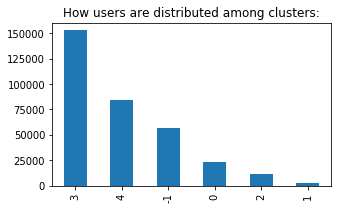

In [66]:
df_aux = df_rent.copy()
print(str(df_aux.label_2.unique().shape[0]) + 'clusters')
plt.figure(figsize=(5, 3))
plt.title('How users are distributed among clusters:')
pd.value_counts(df_aux['label_2'], normalize=False).plot.bar()
plt.show()

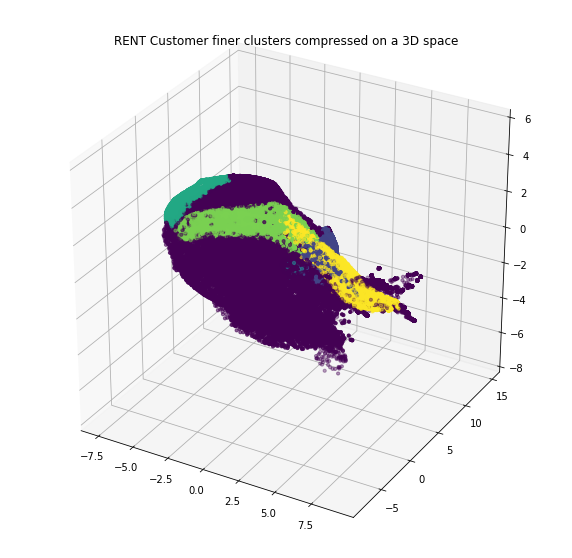

In [72]:
df_plot = df_aux.copy()
#df_plot = df_aux[df_aux.label.isin([2])]
df_plot = df_aux[df_aux.label_probability_2<=treshold]
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(df_plot['umap_dim_3'], 
             df_plot['umap_dim_2'], 
             df_plot['umap_dim_1'], 
             c=df_plot['label_2'], 
             s=10, 
             #alpha=0.03, 
             label=df_plot['label_2'])
plt.title('RENT Customer finer clusters compressed on a 3D space')
#legend = ax.legend(loc="lower left", title="Classes")
plt.show()

In [73]:
df_rent.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3,label_2,label_probability_2
Marketing_Cloud_Visitor_ID,,,,,
00000107708722978450827756473807907358,1.862862,-3.838513,3.362385,-1,0.000000
00000136845845092372076348413986631894,2.388601,-0.954339,1.747901,3,0.914677


In [74]:
df_rent.to_csv('Data/202001_android_rent_clustered_finer.csv', index=True)

# Merging 2 clustering

In [2]:
cl1 = pd.read_csv('Data/202001_android_rent_clustered.csv', index_col='Marketing_Cloud_Visitor_ID')
cl2 = pd.read_csv('Data/202001_android_rent_clustered_finer.csv', index_col='Marketing_Cloud_Visitor_ID')
cl = pd.merge(cl1, cl2[['label_2', 'label_probability_2']], on='Marketing_Cloud_Visitor_ID', how='left')

In [3]:
print('These are culsters from clustering 1:')
print(cl['label'].unique())
print('These are clusters from clustering 1 that are finer clustered in clustering 2:')
l = cl[cl.label_2.isna()==False].label.unique()
print(l)

These are culsters from clustering 1:
[3 1 2 0]
These are clusters from clustering 1 that are finer clustered in clustering 2:
[3]


In [4]:
print('We rename clusters from clustering 2 from:')
print(cl['label_2'].unique())
cl['label_2'] = cl['label_2'] + cl['label'].max()+2
print('to:')
print(cl['label_2'].unique())

We rename clusters from clustering 2 from:
[-1.  3.  0.  4.  2. nan  1.]
to:
[ 4.  8.  5.  9.  7. nan  6.]


In [5]:
# merge label and label probability columns
cl.loc[cl.label.isin(l), ('label_probability')] = cl.label_probability_2
cl.loc[cl.label.isin(l), ('label')] = cl.label_2
cl = cl.drop(columns=['label_probability_2','label_2'])
cl.label.unique()

array([4., 8., 5., 9., 7., 1., 2., 0., 6.])

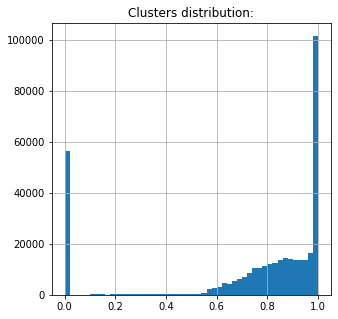

In [6]:
plt.figure(figsize=(5, 5))
plt.title('Clusters distribution:')
cl['label_probability'].hist(bins=50)
plt.show()

In [7]:
treshold = 0.95
print('With confidence level: ' + str(treshold))
m = cl[cl.label_probability>=treshold].shape[0]
n = round(m/cl.shape[0]*100, 2)                                                         
print('We can cluster ' + str(n) + '% of users')

With confidence level: 0.95
We can cluster 34.03% of users


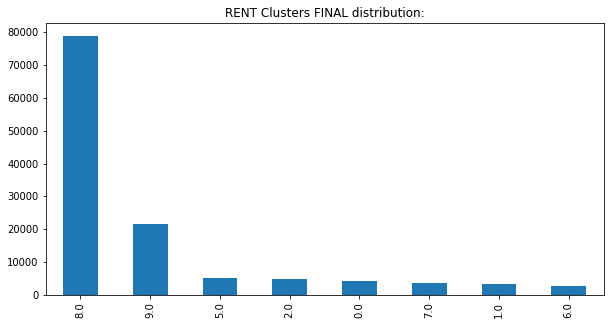

In [13]:
plt.figure(figsize=(10, 5))
plt.title('RENT Clusters FINAL distribution:')
pd.value_counts(cl[cl.label_probability>=0.95]['label'], normalize=False).plot.bar()
plt.show()

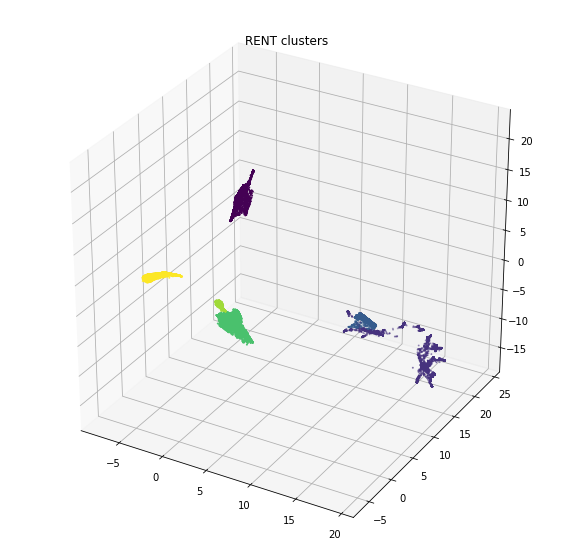

In [14]:
#df_plot = cl.copy()
df_plot = cl[cl.label.isin([2, 5, 0, 7, 1, 6]) & cl.label_probability>=0.98]
plt.figure(figsize=(10, 10))
ax = plt.gca(projection='3d')
ax.scatter3D(df_plot['umap_dim_3'], 
             df_plot['umap_dim_2'], 
             df_plot['umap_dim_1'], 
             c=df_plot['label'], 
             label=df_plot['label'],
             s=1, 
             #alpha=0.01,
             cmap='viridis')
plt.title('RENT clusters')
#plt.legend()
#legend = ax.legend(loc="lower left", title="Classes")
plt.show()

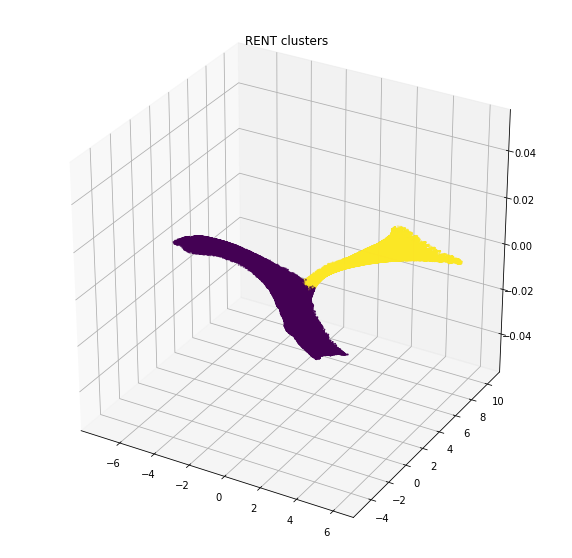

In [16]:
#df_plot = cl.copy()
df_plot = cl[cl.label.isin([8, 9]) & cl.label_probability>=0.98]
plt.figure(figsize=(10, 10))
ax = plt.gca(projection='3d')
ax.scatter3D(df_plot['umap_dim_3'], 
             df_plot['umap_dim_2'], 
             #df_plot['umap_dim_1'], 
             c=df_plot['label'], 
             label=df_plot['label'],
             s=1, 
             #alpha=0.01,
             cmap='viridis')
plt.title('RENT clusters')
#plt.legend()
#legend = ax.legend(loc="lower left", title="Classes")
plt.show()

In [9]:
cl.label.unique()

array([4., 8., 5., 9., 7., 1., 2., 0., 6.])

In [10]:
cl.head(2)

,umap_dim_1,umap_dim_2,umap_dim_3,label,label_probability
Marketing_Cloud_Visitor_ID,,,,,
00000107708722978450827756473807907358,1.862862,-3.838513,3.362385,4.0,0.000000
00000136845845092372076348413986631894,2.388601,-0.954339,1.747901,8.0,0.914677


In [11]:
cl.to_csv('Data/202001_android_rent_clustered_final.csv', index=True)

In [12]:
cl.shape

(366541, 5)

# Visualization

In [23]:
cl = pd.read_csv('Data/202001_android_sale_clustered.csv', index_col='Marketing_Cloud_Visitor_ID')

In [24]:
cl1 = cl[cl.label_probability>=0.95]

In [25]:
cl.shape

(269284, 5)

In [26]:
print(cl1.shape[0]/cl.shape[0])

0.5048870337636102


In [27]:
cl1.label.unique()

array([4, 6, 0, 5, 1, 3, 2, 7])

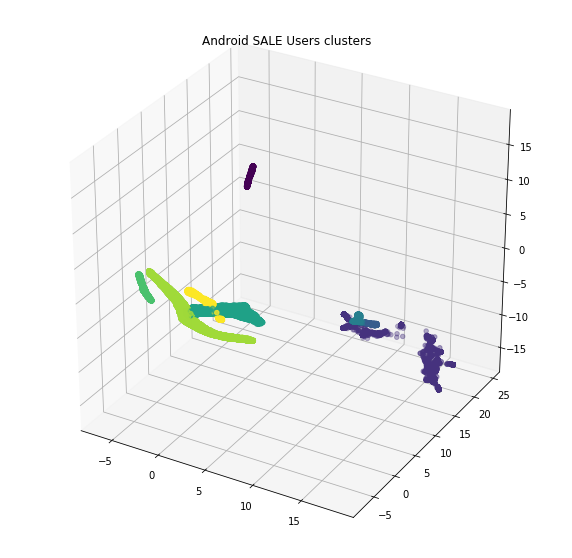

In [28]:
df_plot = cl1.copy()
#df_plot = cl[cl.label.isin([2, 5, 0, 7, 1, 6]) & cl.label_probability>=0.98]
plt.figure(figsize=(10, 10))
ax = plt.gca(projection='3d')
ax.scatter3D(df_plot['umap_dim_3'], 
             df_plot['umap_dim_2'], 
             df_plot['umap_dim_1'], 
             c=df_plot['label'], 
             label=df_plot['label'],
             #s=1, 
             #alpha=0.01,
             cmap='viridis')
plt.title('Android SALE Users clusters')
#plt.legend()
#legend = ax.legend(loc="lower left", title="Classes")
plt.show()